In [1]:
import os
import re
import time
from pathlib import Path
import shutil
import glob
import string
import unicodedata
from datetime import datetime, timedelta

import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.select import Select
from sqlalchemy import create_engine
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

from unicodedata import normalize, category

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stopset = set(stopwords.words("spanish"))
print(stopset)

{'tuyos', 'habrías', 'tendrán', 'seríais', 'sin', 'mucho', 'han', 'tendrás', 'estarán', 'algunos', 'hayan', 'estados', 'al', 'ya', 'nosotras', 'haya', 'estuve', 'tuvierais', 'estaríamos', 'seamos', 'tuvieron', 'de', 'estaba', 'tuyo', 'quienes', 'estuvieses', 'tuvisteis', 'tendrían', 'eran', 'teníamos', 'fuerais', 'tengáis', 'lo', 'la', 'teníais', 'estadas', 'estaríais', 'habría', 'esto', 'somos', 'erais', 'hubiesen', 'fuiste', 'estén', 'mi', 'fueron', 'tened', 'fuésemos', 'fuéramos', 'todos', 'tuve', 'durante', 'muy', 'tenido', 'habréis', 'tuviste', 'pero', 'seáis', 'una', 'tuviese', 'tuyas', 'ellos', 'el', 'sentidos', 'un', 'del', 'fuisteis', 'serán', 'desde', 'sentidas', 'sentida', 'nosotros', 'sería', 'he', 'habrían', 'estaréis', 'tu', 'él', 'poco', 'más', 'hube', 'estabas', 'tenemos', 'estará', 'nada', 'fuesen', 'hubiste', 'suyas', 'tenga', 'todo', 'hubieses', 'tengan', 'otra', 'estuviésemos', 'su', 'sea', 'siente', 'estada', 'hubiéramos', 'hubierais', 'era', 'seremos', 'fue', 'ten

In [3]:
tweets = pd.read_csv('ejercicio_tuits.csv', encoding='ISO-8859-1')

if 'Unnamed: 0' in tweets.columns:
    del tweets['Unnamed: 0']
    
tweets['created_date'] = pd.to_datetime(tweets['created'])
tweets['periodo'] = tweets['created_date'].apply(lambda x: x.strftime('%Y%m'))
tweets['n_words'] = tweets['text'].apply(lambda _: len(_.split()))

tweets.head(50)

,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude,created_date,periodo,n_words
0,Este equipo multisectorial inspeccionará los c...,False,12,Minsa_Peru,2020-05-19 16:13:30,True,1.262778e+18,1262778415461138438,138471254.0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Minsa_Peru,2,False,False,NaN,NaN,2020-05-19 16:13:30,202005,17
1,Estos fueron entregados por el viceministro de...,False,12,Minsa_Peru,2020-05-19 16:13:29,True,1.262778e+18,1262778414467026946,138471254.0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Minsa_Peru,1,False,False,NaN,NaN,2020-05-19 16:13:29,202005,18
2,"Hoy, llevamos 2.2 toneladas en equipos de prot...",False,66,NaN,2020-05-19 16:13:29,True,NaN,1262778412629995521,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Minsa_Peru,8,False,False,NaN,NaN,2020-05-19 16:13:29,202005,20
3,Proteger la salud de los niños<U+0001F466><U+0...,False,78,NaN,2020-05-19 15:07:29,True,NaN,1262761804603617289,NaN,"<a href=""https://studio.twitter.com"" rel=""nofo...",Minsa_Peru,26,False,False,NaN,NaN,2020-05-19 15:07:29,202005,22
4,"Durante los 15 días de aislamiento, los pacien...",False,242,NaN,2020-05-19 01:30:00,True,NaN,1262556076643241985,NaN,"<a href=""https://about.twitter.com/products/tw...",Minsa_Peru,57,False,False,NaN,NaN,2020-05-19 01:30:00,202005,19
5,¡Seguimos protegiendo a los más vulnerables! E...,False,239,NaN,2020-05-19 00:58:55,True,NaN,1262548255759634433,NaN,"<a href=""http://twitter.com/download/android"" ...",Minsa_Peru,48,False,False,NaN,NaN,2020-05-19 00:58:55,202005,18
6,Ministro @victorzamora: La próxima semana expe...,False,160,Minsa_Peru,2020-05-18 22:52:25,True,1.262516e+18,1262516417963986951,138471254.0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Minsa_Peru,31,False,False,NaN,NaN,2020-05-18 22:52:25,202005,17
7,Ministro @victorzamora: Agradezco el apoyo sol...,False,127,Minsa_Peru,2020-05-18 22:52:24,True,1.262516e+18,1262516416764395522,138471254.0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Minsa_Peru,21,False,False,NaN,NaN,2020-05-18 22:52:24,202005,17
8,Ministro @victorzamora: Gracias a todos los tr...,False,60,Minsa_Peru,2020-05-18 22:52:24,True,1.262516e+18,1262516415665524737,138471254.0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Minsa_Peru,12,False,False,NaN,NaN,2020-05-18 22:52:24,202005,17
9,El embajador de la República Popular China en ...,False,76,Minsa_Peru,2020-05-18 22:52:24,True,1.262516e+18,1262516413757038592,138471254.0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Minsa_Peru,19,False,False,NaN,NaN,2020-05-18 22:52:24,202005,22


### NULOS

In [4]:
tweets.isnull().sum()

text                0
favorited           0
favoriteCount       0
replyToSN         785
created             0
truncated           0
replyToSID        791
id                  0
replyToUID        785
statusSource        0
screenName          0
retweetCount        0
isRetweet           0
retweeted           0
longitude        1073
latitude         1073
created_date        0
periodo             0
n_words             0
dtype: int64

### LIMPIANDO STOPWORDS POR DEFECTO

In [7]:
from unicodedata import normalize, category

def clean_text_1(_text):
    """
        Ll : minusculas
        Zs : espacios
        Lu : mayusculas
        Nd : numeros
        Mn : tildes
        Ps : abre dieresis, .....
        Pe : cierra dieresis, .......
        Pi : abre parentesis, .....
        Po : cierra parentesis, punto, coma, .....        
        ...
    """
    selects_characters = ['Ll', 'Zs', 'Lu']
    
    return ''.join([_.lower() for _ in normalize('NFD', _text.replace(' ', 'ZZZ')) if category(_) in selects_characters])

stopset_cleaned = [clean_text_1(word) for word in stopset]
print(stopset_cleaned)

['tuyos', 'habrias', 'tendran', 'seriais', 'sin', 'mucho', 'han', 'tendras', 'estaran', 'algunos', 'hayan', 'estados', 'al', 'ya', 'nosotras', 'haya', 'estuve', 'tuvierais', 'estariamos', 'seamos', 'tuvieron', 'de', 'estaba', 'tuyo', 'quienes', 'estuvieses', 'tuvisteis', 'tendrian', 'eran', 'teniamos', 'fuerais', 'tengais', 'lo', 'la', 'teniais', 'estadas', 'estariais', 'habria', 'esto', 'somos', 'erais', 'hubiesen', 'fuiste', 'esten', 'mi', 'fueron', 'tened', 'fuesemos', 'fueramos', 'todos', 'tuve', 'durante', 'muy', 'tenido', 'habreis', 'tuviste', 'pero', 'seais', 'una', 'tuviese', 'tuyas', 'ellos', 'el', 'sentidos', 'un', 'del', 'fuisteis', 'seran', 'desde', 'sentidas', 'sentida', 'nosotros', 'seria', 'he', 'habrian', 'estareis', 'tu', 'el', 'poco', 'mas', 'hube', 'estabas', 'tenemos', 'estara', 'nada', 'fuesen', 'hubiste', 'suyas', 'tenga', 'todo', 'hubieses', 'tengan', 'otra', 'estuviesemos', 'su', 'sea', 'siente', 'estada', 'hubieramos', 'hubierais', 'era', 'seremos', 'fue', 'ten

### LIMPIANDO TWEETS

In [8]:
#!pip install spacy                                  -- descomentar la 1era vez

In [9]:
#!pip install stanza                                 -- descomentar la 1era vez

In [10]:
#!pip install "spacy-stanza<0.3.0" --user            -- descomentar la 1era vez

In [11]:
import stanza

In [12]:
#stanza.download('es')                                -- descomentar la 1era vez

In [13]:
from spacy_stanza import StanzaLanguage

In [14]:
snlp = stanza.Pipeline(lang="es")
nlp = StanzaLanguage(snlp)

2021-10-03 02:12:14 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2021-10-03 02:12:15 INFO: Use device: cpu
2021-10-03 02:12:15 INFO: Loading: tokenize
2021-10-03 02:12:15 INFO: Loading: mwt
2021-10-03 02:12:15 INFO: Loading: pos
2021-10-03 02:12:16 INFO: Loading: lemma
2021-10-03 02:12:16 INFO: Loading: depparse
2021-10-03 02:12:17 INFO: Loading: ner
2021-10-03 02:12:18 INFO: Done loading processors!


#### Ampliando STOPWORDS

In [15]:
print(len(stopset_cleaned))
stopset_cleaned = stopset_cleaned + ['caption', 'image']
print(len(stopset_cleaned))

313
315


### LEMMATIZACION QUITANDO STOP WORDS

In [16]:
import swifter

In [17]:
import functools

def clean_tweet(new):
    tokenizacion = [
        [
           ''.join([token.lemma_ for token in nlp(clean_text_1(_))]) for _ in nltk.word_tokenize(sentence) 
                         if len(clean_text_1(_)) > 0 and clean_text_1(_) not in stopset_cleaned
        ] for sentence in nltk.sent_tokenize(new)
    ]
    
    return " ".join(functools.reduce(lambda x ,y : x + y , tokenizacion))+" "


tweets['tweet_cleaned'] = tweets['text'].swifter.apply(clean_tweet)

<ipython-input-17-7794f3151030>:6: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  ''.join([token.lemma_ for token in nlp(clean_text_1(_))]) for _ in nltk.word_tokenize(sentence)
<ipython-input-17-7794f3151030>:6: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['tcogyyclr', 'm<UNK>']
Entities: []
  ''.join([token.lemma_ for token in nlp(clean_text_1(_))]) for _ in nltk.word_tokenize(sentence)


In [18]:
tweets.tail(10)

,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude,created_date,periodo,n_words,tweet_cleaned
1063,Si algo hay que reconocerle a la señora K es q...,False,2354,NaN,2020-01-29 15:22:30,True,NaN,1222540528425865216,NaN,"<a href=""http://twitter.com/download/iphone"" r...",DanielUrresti1,319,False,False,NaN,NaN,2020-01-29 15:22:30,202001,26,reconocer senora k valiente ag esperar agente ...
1064,¿Cuál es su fuente?\r\nHe tratado de verificar...,False,350,NaN,2020-01-29 03:40:34,True,NaN,1222363882896924672,NaN,"<a href=""http://twitter.com/download/iphone"" r...",DanielUrresti1,37,False,False,NaN,NaN,2020-01-29 03:40:34,202001,21,fuente tratar verificar abogada ninguno notifi...
1065,@jgodoym ¿Cuál es su fuente?\r\nHe tratado de ...,False,120,jgodoym,2020-01-29 03:39:54,False,1.222304e+18,1222363714759876608,5418002.0,"<a href=""http://twitter.com/download/iphone"" r...",DanielUrresti1,10,False,False,NaN,NaN,2020-01-29 03:39:54,202001,21,jgodoym fuente tratar verificar abogada ningun...
1066,@elhigadodmarita Mi estimada Sra a qué se refi...,False,22,elhigadodmarita,2020-01-28 22:06:49,True,1.222155e+18,1222279892823351304,79124132.0,"<a href=""http://twitter.com/download/iphone"" r...",DanielUrresti1,6,False,False,NaN,NaN,2020-01-28 22:06:49,202001,19,elhigadodmarita estimar sra referir repartidor...
1067,"Sra. Chávez, ud. no está al nivel de Mulder pa...",False,1087,NaN,2020-01-28 21:49:54,True,NaN,1222275634040315905,NaN,"<a href=""http://twitter.com/download/iphone"" r...",DanielUrresti1,308,False,False,NaN,NaN,2020-01-28 21:49:54,202001,22,sra chavez udo nivel mulder responderlar corre...
1068,"Señores @pagina12, su ""noticia"" es un insulto ...",False,759,NaN,2020-01-28 15:45:54,True,NaN,1222184031921614850,NaN,"<a href=""http://twitter.com/download/iphone"" r...",DanielUrresti1,96,False,False,NaN,NaN,2020-01-28 15:45:54,202001,21,senor pagina noticia insulto casi persona voto...
1069,Lo dice el que lleva a cuestas una una cadena ...,False,1839,NaN,2020-01-28 05:37:14,False,NaN,1222030853381021696,NaN,"<a href=""http://twitter.com/download/iphone"" r...",DanielUrresti1,247,False,False,NaN,NaN,2020-01-28 05:37:14,202001,13,decir llevar cuestas cadena pollerio https tco...
1070,Seré el primer congresista que seguirá un proc...,False,2722,NaN,2020-01-28 02:43:19,True,NaN,1221987086544396290,NaN,"<a href=""http://twitter.com/download/iphone"" r...",DanielUrresti1,277,False,False,NaN,NaN,2020-01-28 02:43:19,202001,19,primero congresista seguir proceso penal cualq...
1071,Confío plenamente en mi inocencia y por eso le...,False,730,NaN,2020-01-28 02:33:23,True,NaN,1221984585581518848,NaN,"<a href=""http://twitter.com/download/android"" ...",DanielUrresti1,109,False,False,NaN,NaN,2020-01-28 02:33:23,202001,21,confiar plenamente inocencia pedir poder judic...
1072,En minutos estaré con @JulianaOxenford por @at...,False,557,NaN,2020-01-28 00:19:13,False,NaN,1221950823489589249,NaN,"<a href=""http://twitter.com/download/iphone"" r...",DanielUrresti1,37,False,False,NaN,NaN,2020-01-28 00:19:13,202001,15,minuto julianaoxenford atvpe invitar seguir en...


In [20]:
tweets.to_csv('tweets_cleaned.csv', index=False)

<AxesSubplot:>

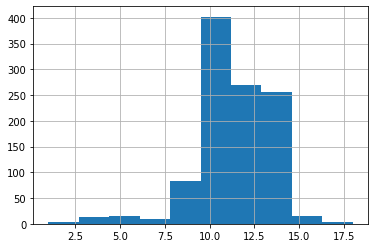

In [22]:
tweets['n_words_cleaned'] = tweets['tweet_cleaned'].apply(lambda _: len(_.split()))
tweets['n_words_cleaned'].hist()

In [26]:
tweets.iloc[:,-10:].head()

,retweetCount,isRetweet,retweeted,longitude,latitude,created_date,periodo,n_words,tweet_cleaned,n_words_cleaned
0,2,False,False,NaN,NaN,2020-05-19 16:13:30,202005,17,equipo multisectorial inspeccionar centro salu...,12
1,1,False,False,NaN,NaN,2020-05-19 16:13:29,202005,18,entregar viceministro prestación aseguramiento...,11
2,8,False,False,NaN,NaN,2020-05-19 16:13:29,202005,20,hoy llevar tonelada equipo proteccion personal...,11
3,26,False,False,NaN,NaN,2020-05-19 15:07:29,202005,22,proteger salud nino uf uf covid mano padre fam...,14
4,57,False,False,NaN,NaN,2020-05-19 01:30:00,202005,19,dia aislamiento paciente covid evaluado perman...,10


In [27]:
tweets.shape

(1073, 21)

### Exploración básica

In [29]:
tweets[['favoriteCount','retweetCount', 'n_words_cleaned']].corr(method='spearman').style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(3)

,favoriteCount,retweetCount,n_words_cleaned
favoriteCount,1.000,0.968,0.103
retweetCount,0.968,1.000,0.106
n_words_cleaned,0.103,0.106,1.000


In [36]:
tweets['periodo'] = pd.PeriodIndex(tweets['periodo'], freq='M')

In [38]:
tweets.dtypes

text                       object
favorited                    bool
favoriteCount               int64
replyToSN                  object
created                    object
truncated                    bool
replyToSID                float64
id                          int64
replyToUID                float64
statusSource               object
screenName                 object
retweetCount                int64
isRetweet                    bool
retweeted                    bool
longitude                 float64
latitude                  float64
created_date       datetime64[ns]
periodo                 period[M]
n_words                     int64
tweet_cleaned              object
n_words_cleaned             int64
dtype: object

periodo
2020-03      9
2020-04    209
2020-05    196
Freq: M, dtype: int64

periodo
2020-04    82
2020-05    73
Freq: M, dtype: int64

periodo
2020-01     22
2020-02     31
2020-03    159
2020-04    167
2020-05    125
Freq: M, dtype: int64

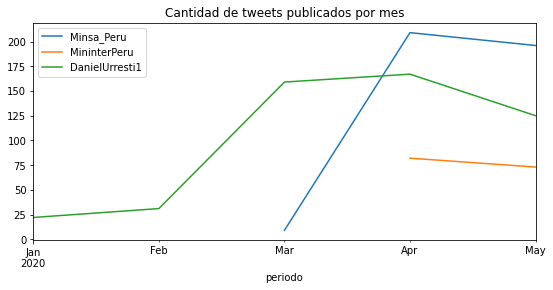

In [43]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
fig, ax = plt.subplots(figsize=(9,4))

for autor in tweets.screenName.unique():
    df_temp = tweets[tweets['screenName'] == autor].copy()
    df_temp = df_temp.groupby(df_temp['periodo']).size()
    display(df_temp)
    df_temp.plot(label=autor, ax=ax)

ax.set_title('Cantidad de tweets publicados por mes')
ax.legend();

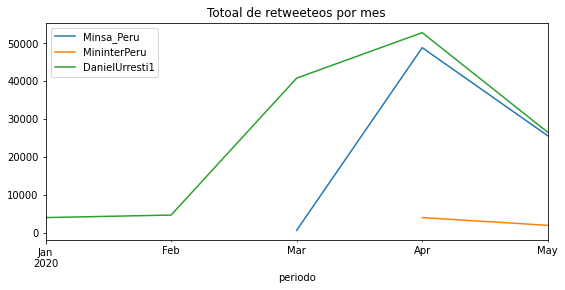

In [51]:
fig, ax = plt.subplots(figsize=(9,4))

for autor in tweets.screenName.unique():
    df_temp = tweets[tweets['screenName'] == autor].copy()
    df_temp = df_temp.groupby(df_temp['periodo']).agg({'retweetCount': sum})['retweetCount']
    df_temp.plot(label=autor, ax=ax)

ax.set_title('Totoal de retweeteos por mes')
ax.legend();

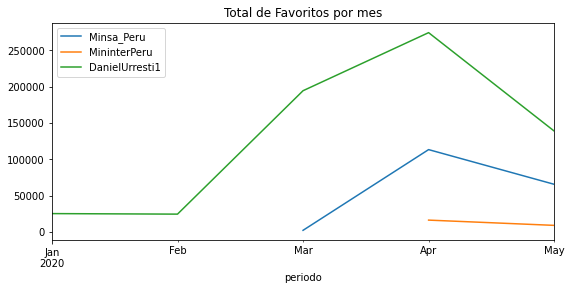

In [50]:
fig, ax = plt.subplots(figsize=(9,4))

for autor in tweets.screenName.unique():
    df_temp = tweets[tweets['screenName'] == autor].copy()
    df_temp = df_temp.groupby(df_temp['periodo']).agg({'favoriteCount': sum})['favoriteCount']
    df_temp.plot(label=autor, ax=ax)

ax.set_title('Total de Favoritos por mes')
ax.legend();

### TOKENS

In [53]:
tweets['texto_tokenizado'] = tweets['tweet_cleaned'].apply(lambda _: _.split())
tweets.iloc[:,-10:].head()

,isRetweet,retweeted,longitude,latitude,created_date,periodo,n_words,tweet_cleaned,n_words_cleaned,texto_tokenizado
0,False,False,NaN,NaN,2020-05-19 16:13:30,2020-05,17,equipo multisectorial inspeccionar centro salu...,12,"[equipo, multisectorial, inspeccionar, centro,..."
1,False,False,NaN,NaN,2020-05-19 16:13:29,2020-05,18,entregar viceministro prestación aseguramiento...,11,"[entregar, viceministro, prestación, asegurami..."
2,False,False,NaN,NaN,2020-05-19 16:13:29,2020-05,20,hoy llevar tonelada equipo proteccion personal...,11,"[hoy, llevar, tonelada, equipo, proteccion, pe..."
3,False,False,NaN,NaN,2020-05-19 15:07:29,2020-05,22,proteger salud nino uf uf covid mano padre fam...,14,"[proteger, salud, nino, uf, uf, covid, mano, p..."
4,False,False,NaN,NaN,2020-05-19 01:30:00,2020-05,19,dia aislamiento paciente covid evaluado perman...,10,"[dia, aislamiento, paciente, covid, evaluado, ..."


In [56]:
tweets_tidy = tweets[['id', 'screenName', 'created_date', 'periodo', 'tweet_cleaned', 'texto_tokenizado']].explode(column='texto_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='tweet_cleaned')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head()

,id,screenName,created_date,periodo,token
0,1262778415461138438,Minsa_Peru,2020-05-19 16:13:30,2020-05,equipo
0,1262778415461138438,Minsa_Peru,2020-05-19 16:13:30,2020-05,multisectorial
0,1262778415461138438,Minsa_Peru,2020-05-19 16:13:30,2020-05,inspeccionar
0,1262778415461138438,Minsa_Peru,2020-05-19 16:13:30,2020-05,centro
0,1262778415461138438,Minsa_Peru,2020-05-19 16:13:30,2020-05,salud


In [57]:
# Palabras totales utilizadas por cada autor
# ==============================================================================
print('--------------------------')
print('Palabras totales por autor')
print('--------------------------')
tweets_tidy.groupby(by='screenName')['token'].count()

--------------------------
Palabras totales por autor
--------------------------


screenName
DanielUrresti1    5664
MininterPeru      1764
Minsa_Peru        4742
Name: token, dtype: int64

In [58]:
# Palabras distintas utilizadas por cada autor
# ==============================================================================
print('----------------------------')
print('Palabras distintas por autor')
print('----------------------------')
tweets_tidy.groupby(by='screenName')['token'].nunique()

----------------------------
Palabras distintas por autor
----------------------------


screenName
DanielUrresti1    2456
MininterPeru       838
Minsa_Peru        1640
Name: token, dtype: int64

In [60]:
# Longitud media y desviación de los tweets de cada autor
# ==============================================================================
temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["screenName", "id"])["token"].count())
temp_df.reset_index().groupby("screenName")["token"].agg(['mean', 'std'])

,mean,std
screenName,,
DanielUrresti1,11.238095,2.375081
MininterPeru,11.380645,1.517307
Minsa_Peru,11.454106,1.523527


In [64]:
print(tweets_tidy.shape)
tweets_tidy = tweets_tidy[tweets_tidy['token'] != 'https']
print(tweets_tidy.shape)

(12170, 5)
(11116, 5)


In [65]:
tweets_tidy.groupby(['screenName','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('screenName') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

screenName            token  count
screenName                                                 
DanielUrresti1 53    DanielUrresti1              afp     74
               1449  DanielUrresti1            poder     57
               442   DanielUrresti1       coronaviru     37
               509   DanielUrresti1            decir     37
               878   DanielUrresti1            hacer     32
MininterPeru   2870    MininterPeru         ministro     96
               2739    MininterPeru  gastonrodriguez     68
               2971    MininterPeru      policiaperu     37
               2560    MininterPeru      carlosmoran     30
               2806    MininterPeru         interior     21
Minsa_Peru     4020      Minsa_Peru         ministro    180
               4901      Minsa_Peru      victorzamor    170
               3572      Minsa_Peru            covid    113
               4319      Minsa_Peru            salud     59
               4135      Minsa_Peru             peru     46

In [68]:
import numpy as np
tweets_tidy['autor'] = tweets_tidy['screenName'].copy()

<ipython-input-68-a146438d3aaf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_tidy['autor'] = tweets_tidy['screenName'].copy()


In [71]:
# Cálculo del log of odds ratio de cada palabra (elonmusk vs mayoredlee)
# ==============================================================================
# Pivotaje y despivotaje
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")

tweets_pivot = tweets_pivot.fillna(value=0)
tweets_pivot.columns.name = None

tweets_unpivot = tweets_pivot.melt(value_name='n', var_name='autor', ignore_index=False)
tweets_unpivot = tweets_unpivot.reset_index()

# Selección de los autores elonmusk y mayoredlee
tweets_unpivot = tweets_unpivot[tweets_unpivot.autor.isin(['DanielUrresti1', 'Minsa_Peru'])]

# Se añade el total de palabras de cada autor
tweets_unpivot = tweets_unpivot.merge(
                    tweets_tidy.groupby('autor')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'autor'
                 )

# Cálculo de odds y log of odds de cada palabra
tweets_logOdds = tweets_unpivot.copy()
tweets_logOdds['odds'] = (tweets_logOdds.n + 1) / (tweets_logOdds.N + 1)
tweets_logOdds = tweets_logOdds[['token', 'autor', 'odds']] \
                    .pivot(index='token', columns='autor', values='odds')
tweets_logOdds.columns.name = None

tweets_logOdds['log_odds']     = np.log(tweets_logOdds['DanielUrresti1']/tweets_logOdds['Minsa_Peru'])
tweets_logOdds['abs_log_odds'] = np.abs(tweets_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de Elon Musk. Esto es así porque el ratio sea ha
# calculado como elonmusk/mayoredlee.
tweets_logOdds['autor_frecuente'] = np.where(tweets_logOdds.log_odds > 0,
                                              'DanielUrresti1', 'Minsa_Peru'
                                    )

In [72]:
print('-----------------------------------')
print('Top 10 palabras más diferenciadoras')
print('-----------------------------------')
tweets_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

-----------------------------------
Top 10 palabras más diferenciadoras
-----------------------------------


,DanielUrresti1,Minsa_Peru,log_odds,abs_log_odds,autor_frecuente
token,,,,,
victorzamor,0.000386,0.039492,-4.627175,4.627175,Minsa_Peru
afp,0.014487,0.000231,4.138830,4.138830,DanielUrresti1
covid,0.000579,0.026328,-3.816244,3.816244,Minsa_Peru
actualizacion,0.000193,0.007621,-3.675166,3.675166,Minsa_Peru
decir,0.007340,0.000231,3.458928,3.458928,DanielUrresti1
mayo,0.000193,0.005312,-3.314152,3.314152,Minsa_Peru
ley,0.005988,0.000231,3.255329,3.255329,DanielUrresti1
paciente,0.000193,0.004850,-3.223181,3.223181,Minsa_Peru
comando,0.000193,0.003926,-3.011872,3.011872,Minsa_Peru


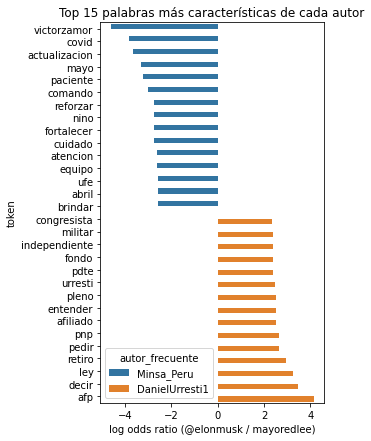

In [73]:
# Top 15 palabras más características de cada autor
# ==============================================================================

top_30 = tweets_logOdds[['log_odds', 'abs_log_odds', 'autor_frecuente']] \
        .groupby('autor_frecuente') \
        .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(4, 7))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'autor_frecuente',
    data = top_30,
    ax   = ax
)
ax.set_title('Top 15 palabras más características de cada autor')
ax.set_xlabel('log odds ratio (@elonmusk / mayoredlee)');

In [74]:
# Pivotado de datos
# ==============================================================================
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")
tweets_pivot.columns.name = None

In [75]:
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

tweets_pivot.corr(method=similitud_coseno)

,DanielUrresti1,MininterPeru,Minsa_Peru
DanielUrresti1,1.000000,0.439013,0.383925
MininterPeru,0.439013,1.000000,0.755147
Minsa_Peru,0.383925,0.755147,1.000000


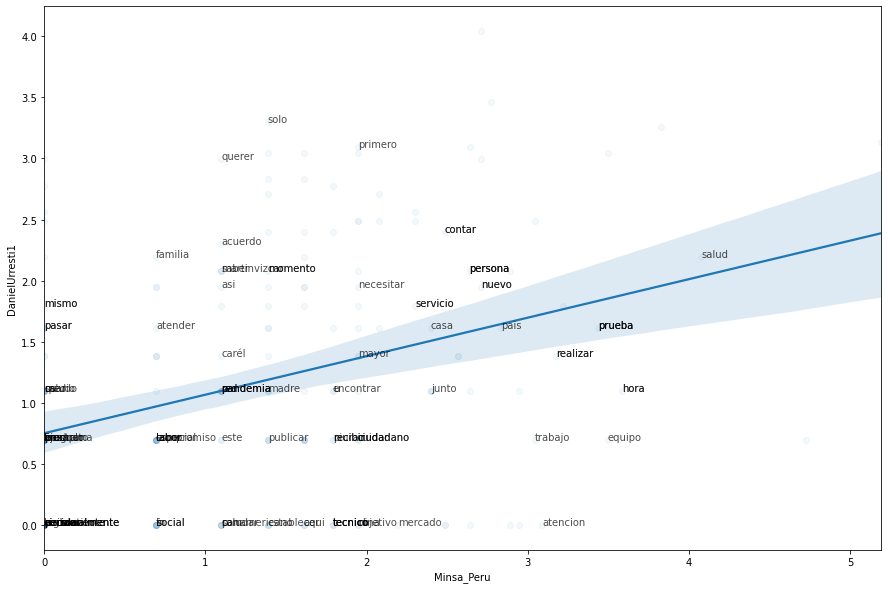

In [78]:
# Gráfico de correlación
# ==============================================================================
f, ax = plt.subplots(figsize=(15, 10))
temp = tweets_pivot.dropna()
sns.regplot(
    x  = np.log(temp.Minsa_Peru),
    y  = np.log(temp.DanielUrresti1),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        text  = temp.index[i],
        xy    = (np.log(temp.Minsa_Peru[i]), np.log(temp.DanielUrresti1[i])),
        alpha = 0.7
    )

In [79]:
tweets_pivot.corr(method=similitud_coseno).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(3)

,DanielUrresti1,MininterPeru,Minsa_Peru
DanielUrresti1,1.000,0.439,0.384
MininterPeru,0.439,1.000,0.755
Minsa_Peru,0.384,0.755,1.000


In [86]:
import gc
gc.collect()

22

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

In [81]:
del tweets_pivot

In [82]:
del tweets_logOdds

In [83]:
del tweets_tidy

In [88]:
del df_temp

In [87]:
import gc
gc.collect()

22

In [95]:
tweets['autor'] = tweets['screenName'].copy()
tweets[['id', 'autor', 'created_date', 'periodo', 'tweet_cleaned']].head()

,id,autor,created_date,periodo,tweet_cleaned
0,1262778415461138438,Minsa_Peru,2020-05-19 16:13:30,2020-05,equipo multisectorial inspeccionar centro salu...
1,1262778414467026946,Minsa_Peru,2020-05-19 16:13:29,2020-05,entregar viceministro prestación aseguramiento...
2,1262778412629995521,Minsa_Peru,2020-05-19 16:13:29,2020-05,hoy llevar tonelada equipo proteccion personal...
3,1262761804603617289,Minsa_Peru,2020-05-19 15:07:29,2020-05,proteger salud nino uf uf covid mano padre fam...
4,1262556076643241985,Minsa_Peru,2020-05-19 01:30:00,2020-05,dia aislamiento paciente covid evaluado perman...


In [96]:
gc.collect()

44

In [93]:
print(len(stopset_cleaned))
stopset_cleaned = stopset_cleaned + ['https']
print(len(stopset_cleaned))

315
316


In [97]:
autores = ['Minsa_Peru', 'DanielUrresti1']
datos_X = tweets.loc[tweets.autor.isin(autores), 'tweet_cleaned']
datos_y = tweets.loc[tweets.autor.isin(autores), 'autor']

In [98]:
datos_X

0       equipo multisectorial inspeccionar centro salu...
1       entregar viceministro prestación aseguramiento...
2       hoy llevar tonelada equipo proteccion personal...
3       proteger salud nino uf uf covid mano padre fam...
4       dia aislamiento paciente covid evaluado perman...
                              ...                        
1068    senor pagina noticia insulto casi persona voto...
1069    decir llevar cuestas cadena pollerio https tco...
1070    primero congresista seguir proceso penal cualq...
1071    confiar plenamente inocencia pedir poder judic...
1072    minuto julianaoxenford atvpe invitar seguir en...
Name: tweet_cleaned, Length: 918, dtype: object

In [101]:
datos_y.value_counts(normalize=True)

DanielUrresti1    0.54902
Minsa_Peru        0.45098
Name: autor, dtype: float64

In [103]:
SEED = 29082013
import random as rn

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [105]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = SEED
    
)

In [107]:
def clean_tweet_list(new):
    tokenizacion = [
        [
           ''.join([token.lemma_ for token in nlp(clean_text_1(_))]) for _ in nltk.word_tokenize(sentence) 
                         if len(clean_text_1(_)) > 0 and clean_text_1(_) not in stopset_cleaned
        ] for sentence in nltk.sent_tokenize(new)
    ]
    
    return list(functools.reduce(lambda x ,y : x + y , tokenizacion))

In [111]:
tfidf_vectorizador = TfidfVectorizer(
                        tokenizer  = clean_tweet_list,
                        min_df     = 0.01,
                        max_df     = 0.9,
                        stop_words = stopset_cleaned
                    )
tfidf_vectorizador.fit(X_train)

TfidfVectorizer(max_df=0.9, min_df=0.01,
                stop_words=['tuyos', 'habrias', 'tendran', 'seriais', 'sin',
                            'mucho', 'han', 'tendras', 'estaran', 'algunos',
                            'hayan', 'estados', 'al', 'ya', 'nosotras', 'haya',
                            'estuve', 'tuvierais', 'estariamos', 'seamos',
                            'tuvieron', 'de', 'estaba', 'tuyo', 'quienes',
                            'estuvieses', 'tuvisteis', 'tendrian', 'eran',
                            'teniamos', ...],
                tokenizer=<function clean_tweet_list at 0x000001D22DD2D9D0>)

In [112]:
tfidf_train = tfidf_vectorizador.transform(X_train)
tfidf_test  = tfidf_vectorizador.transform(X_test)

In [113]:
print(f" Número de tokens creados: {len(tfidf_vectorizador.get_feature_names())}")
print(tfidf_vectorizador.get_feature_names()[:10])

 Número de tokens creados: 163
['abril', 'accion', 'actualizacion', 'acuerdo', 'afiliado', 'afp', 'ahora', 'alcalde', 'ano', 'asi']


### MODELAMIENTO

In [114]:
# Entrenamiento del modelo SVM
# ==============================================================================
modelo_svm_lineal = svm.SVC(kernel= "linear")
modelo_svm_lineal.fit(X=tfidf_train, y= y_train)

SVC(kernel='linear')

In [122]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {
    'C': np.logspace(-5, 3, 50),
    'shrinking': [True, False],
    'probability': [True, False],
    'class_weight': ['balanced', None]
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = svm.SVC(kernel= "linear"),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = tfidf_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False).head(10)

,param_C,param_class_weight,param_probability,param_shrinking,mean_test_score,std_test_score,mean_train_score,std_train_score
240,0.790604,balanced,True,True,0.922365,0.020387,0.948570,0.003468
241,0.790604,balanced,True,False,0.922365,0.020387,0.948570,0.003468
242,0.790604,balanced,False,True,0.922365,0.020387,0.948570,0.003468
243,0.790604,balanced,False,False,0.922365,0.020387,0.948570,0.003468
225,0.372759,balanced,True,False,0.918265,0.008526,0.941415,0.005137
...,...,...,...,...,...,...,...,...
42,0.000066,balanced,False,True,0.525785,0.036865,0.527272,0.035745
41,0.000066,balanced,True,False,0.525785,0.036865,0.527272,0.035745
40,0.000066,balanced,True,True,0.525785,0.036865,0.527272,0.035745
27,0.000031,balanced,False,False,0.525785,0.036865,0.527272,0.035745


In [128]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False).head(10)

,param_C,param_class_weight,param_probability,param_shrinking,mean_test_score,std_test_score,mean_train_score,std_train_score
240,0.790604,balanced,True,True,0.922365,0.020387,0.948570,0.003468
241,0.790604,balanced,True,False,0.922365,0.020387,0.948570,0.003468
242,0.790604,balanced,False,True,0.922365,0.020387,0.948570,0.003468
243,0.790604,balanced,False,False,0.922365,0.020387,0.948570,0.003468
225,0.372759,balanced,True,False,0.918265,0.008526,0.941415,0.005137
227,0.372759,balanced,False,False,0.918265,0.008526,0.941415,0.005137
226,0.372759,balanced,False,True,0.918265,0.008526,0.941415,0.005137
224,0.372759,balanced,True,True,0.918265,0.008526,0.941415,0.005137
251,1.151395,balanced,False,False,0.916914,0.018877,0.951635,0.003828
250,1.151395,balanced,False,True,0.916914,0.018877,0.951635,0.003828


In [124]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_final = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 0.7906043210907685, 'class_weight': 'balanced', 'probability': True, 'shrinking': True} : 0.9223651104277326 accuracy


In [127]:
predicciones_test = modelo_final.predict(X=tfidf_test)

print("-------------")
print("Error de test")
print("-------------")

print(f"Número de clasificaciones erróneas de un total de {tfidf_test.shape[0]} " \
      f"clasificaciones: {(y_test != predicciones_test).sum()}"
)
print(f"% de error: {100*(y_test != predicciones_test).mean()}")

print("")
print("-------------------")
print("Matriz de confusión")

print("-------------------")

pd.DataFrame(
    confusion_matrix(
        y_true = y_test, 
        y_pred= predicciones_test
    ),
    columns= autores,
    index = autores
).style.background_gradient(axis=0)

-------------
Error de test
-------------
Número de clasificaciones erróneas de un total de 184 clasificaciones: 17
% de error: 9.239130434782608

-------------------
Matriz de confusión
-------------------


,Minsa_Peru,DanielUrresti1
Minsa_Peru,100,4
DanielUrresti1,13,67


In [129]:
# Entrenamiento del modelo SVM
# ==============================================================================
modelo_svm_lineal = svm.SVC(kernel= "sigmoid")
modelo_svm_lineal.fit(X=tfidf_train, y= y_train)

SVC(kernel='sigmoid')

In [130]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {
    'C': np.logspace(-5, 3, 50),
    'shrinking': [True, False],
    'probability': [True, False],
    'class_weight': ['balanced', None],
    'gamma': ['scale', 'auto']
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = svm.SVC(kernel= "sigmoid"),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = tfidf_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False).head(10)

,param_C,param_class_weight,param_gamma,param_probability,param_shrinking,mean_test_score,std_test_score,mean_train_score,std_train_score
505,1.151395,None,scale,True,False,0.918274,0.017669,0.929838,0.005522
709,152.641797,balanced,auto,True,False,0.918274,0.019653,0.949591,0.002306
711,152.641797,balanced,auto,False,False,0.918274,0.019653,0.949591,0.002306
708,152.641797,balanced,auto,True,True,0.918274,0.019653,0.949591,0.002306
695,104.811313,balanced,auto,False,False,0.918274,0.020573,0.945845,0.003473
694,104.811313,balanced,auto,False,True,0.918274,0.020573,0.945845,0.003473
693,104.811313,balanced,auto,True,False,0.918274,0.020573,0.945845,0.003473
692,104.811313,balanced,auto,True,True,0.918274,0.020573,0.945845,0.003473
504,1.151395,None,scale,True,True,0.918274,0.017669,0.929838,0.005522
710,152.641797,balanced,auto,False,True,0.918274,0.019653,0.949591,0.002306


In [132]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_final = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 1.1513953993264456, 'class_weight': None, 'gamma': 'scale', 'probability': True, 'shrinking': True} : 0.91827415897866 accuracy


In [133]:
predicciones_test = modelo_final.predict(X=tfidf_test)

print("-------------")
print("Error de test")
print("-------------")

print(f"Número de clasificaciones erróneas de un total de {tfidf_test.shape[0]} " \
      f"clasificaciones: {(y_test != predicciones_test).sum()}"
)
print(f"% de error: {100*(y_test != predicciones_test).mean()}")

print("")
print("-------------------")
print("Matriz de confusión")

print("-------------------")

pd.DataFrame(
    confusion_matrix(
        y_true = y_test, 
        y_pred= predicciones_test
    ),
    columns= autores,
    index = autores
).style.background_gradient(axis=0)

-------------
Error de test
-------------
Número de clasificaciones erróneas de un total de 184 clasificaciones: 16
% de error: 8.695652173913043

-------------------
Matriz de confusión
-------------------


,Minsa_Peru,DanielUrresti1
Minsa_Peru,101,3
DanielUrresti1,13,67


In [134]:
# Entrenamiento del modelo SVM
# ==============================================================================
modelo_svm_lineal = svm.SVC(kernel= "poly")
modelo_svm_lineal.fit(X=tfidf_train, y= y_train)

SVC(kernel='poly')

In [138]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {
    'C': np.logspace(-5, 3, 50),
    'shrinking': [True, False],
    'probability': [True, False],
    'class_weight': ['balanced', None],
    'gamma': ['scale', 'auto'],
    'degree': [1, 2, 3, 4]
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = svm.SVC(kernel= "poly"),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = tfidf_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False).head(10)

,param_C,param_class_weight,param_degree,param_gamma,param_probability,param_shrinking,mean_test_score,std_test_score,mean_train_score,std_train_score
1923,0.790604,balanced,1,scale,False,False,0.919635,0.021199,0.948911,0.003038
1920,0.790604,balanced,1,scale,True,True,0.919635,0.021199,0.948911,0.003038
1921,0.790604,balanced,1,scale,True,False,0.919635,0.021199,0.948911,0.003038
1922,0.790604,balanced,1,scale,False,True,0.919635,0.021199,0.948911,0.003038
2820,152.641797,balanced,1,auto,True,True,0.918274,0.019653,0.949591,0.002306
2756,104.811313,balanced,1,auto,True,True,0.918274,0.020573,0.945845,0.003473
2759,104.811313,balanced,1,auto,False,False,0.918274,0.020573,0.945845,0.003473
2823,152.641797,balanced,1,auto,False,False,0.918274,0.019653,0.949591,0.002306
2822,152.641797,balanced,1,auto,False,True,0.918274,0.019653,0.949591,0.002306
2821,152.641797,balanced,1,auto,True,False,0.918274,0.019653,0.949591,0.002306


In [139]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_final = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 0.7906043210907685, 'class_weight': 'balanced', 'degree': 1, 'gamma': 'scale', 'probability': True, 'shrinking': True} : 0.919634703196347 accuracy


In [140]:
predicciones_test = modelo_final.predict(X=tfidf_test)

print("-------------")
print("Error de test")
print("-------------")

print(f"Número de clasificaciones erróneas de un total de {tfidf_test.shape[0]} " \
      f"clasificaciones: {(y_test != predicciones_test).sum()}"
)
print(f"% de error: {100*(y_test != predicciones_test).mean()}")

print("")
print("-------------------")
print("Matriz de confusión")

print("-------------------")

pd.DataFrame(
    confusion_matrix(
        y_true = y_test, 
        y_pred= predicciones_test
    ),
    columns= autores,
    index = autores
).style.background_gradient(axis=0)

-------------
Error de test
-------------
Número de clasificaciones erróneas de un total de 184 clasificaciones: 17
% de error: 9.239130434782608

-------------------
Matriz de confusión
-------------------


,Minsa_Peru,DanielUrresti1
Minsa_Peru,100,4
DanielUrresti1,13,67
